# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Импортируем библиотеки**

In [1]:
!pip install phik

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LinearRegression
import lightgbm as lgb
import time

import phik

In [2]:
data = pd.read_csv("/datasets/autos.csv")
display(data)
print(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Проанализируем фрейм**

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


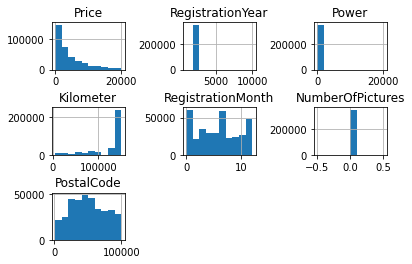

In [3]:
data.hist() 
plt.subplots_adjust(wspace=.8, hspace=.8)

data.describe() 

**Обработаем целевой признак  Price, минимальное значение 0, заполнять по средней цене некорректно, поэтому удалим эти данные**

In [4]:
len(data.loc[data['Price'] == 0])

10772

In [5]:
data = data.loc[data['Price'] != 0]
len(data.loc[data['Price'] == 0])

0

**Обработаем количественные признаки**

**RegistrationYear**

                  counted
RegistrationYear         
1960                  136
1961                   38
1962                   40
1963                   55
1964                   60
1965                   80
1966                  110
1967                   94
1968                  105
1969                  117
1970                  284
1971                  159
1972                  210
1973                  165
1974                  167
1975                  137
1976                  157
1977                  169
1978                  276
1979                  267
1980                  490
1981                  249
1982                  300
1983                  403
1984                  382
1985                  667
1986                  502
1987                  627
1988                  903
1989                 1235
1990                 2458
1991                 2609
1992                 2853
1993                 3268
1994                 4615
1995                 8953
1996        

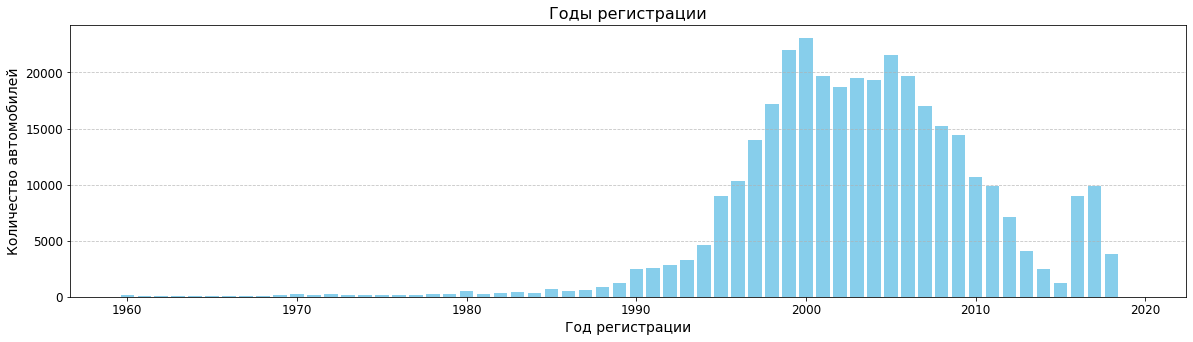

In [6]:
data = data.loc[(data['RegistrationYear'] <= 2024) & (data['RegistrationYear'] >= 1960)]
data_years = data.pivot_table(index='RegistrationYear', values='Brand', aggfunc='count')
data_years.columns = ['counted']
print (data_years)
fig, ax = plt.subplots(figsize=(20, 5))  
ax.bar(data_years.index, data_years.counted, color='skyblue')

# Настройка графика
ax.set_title('Годы регистрации', fontsize=16)
ax.set_xlabel('Год регистрации', fontsize=14)
ax.set_ylabel('Количество автомобилей', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Отображение сетки
ax.grid(True, axis='y', linestyle='--', alpha=0.75)

plt.show()

In [7]:
data.DateCrawled.max()

'2016-04-07 14:36:58'

Так как выгрузка 2016 года, ограничим ее этим годом, нижнюю границу выставлю так, чтобы не было выбросов (например раритетных авто)

In [8]:
data = data.loc[(data['RegistrationYear'] <= 2016) & (data['RegistrationYear'] >= 1950)]

**Power**

In [9]:
data['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,    60,   136,   160,   231,    50,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   286,   232,   150,
         156,    80,    82,    90,   155,    54,   185,    87,   180,
          86,    84,   224,   235,   200,   178,   265,    77,   110,
         144,   120,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
         145,   280,   260,   104,   188,   333,   186,   117,   141,
         132,   234,   158,    39,    92,    51,   135,    59,   230,
          53,   209,

 Уберем значения равные 0 и более 1000, заменим их на медианные значения.

In [10]:
data.loc[(data['Power'] > 1000) | (data['Power'] <= 0), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.loc[~data['Power'].isna()]
data['Power'] = data['Power'].astype('int64')
data['Power'].unique()

array([ 101,  190,  163,   75,   69,  102,  109,  125,  105,  140,  115,
        131,   60,  136,  160,  231,   50,  118,  193,   99,  113,  218,
        122,  129,   70,  306,   95,   61,  177,  170,   55,  143,  155,
        286,  232,  150,  156,   80,   82,   90,   54,  185,   87,  180,
         86,   84,  224,  235,  200,  178,  265,   77,  110,  144,  120,
        116,  184,  126,  204,  133,   88,  194,   64,  305,  197,  179,
        250,   45,  245,  313,   41,  165,   98,  130,  114,  211,   56,
        201,  213,   58,  107,   83,  174,  100,  220,   73,  192,   68,
         66,  299,   74,   52,  147,  310,   71,   97,   65,  239,  203,
          5,  300,  103,   85,  258,  320,   63,   81,  148,   44,  145,
        280,  260,  104,  188,  333,  186,  117,  141,  132,  234,  158,
         39,   92,   51,  135,   59,  230,   53,  209,   43,  146,   67,
        106,  166,  340,  276,  344,   72,  249,  237,  111,  326,  279,
         23,  138,  175,   96,  226,   26,   37,  3

**Kilometer**

In [11]:
data['Kilometer'].unique()

array([150000, 125000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000])

Данные в порядке 

**RegistrationMonth**

In [12]:
data['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

**NumberOfPictures**

In [13]:
data['NumberOfPictures'].unique()

array([0])

Нет никаких данных,удалим данный столбец

In [14]:
data = data.drop(['NumberOfPictures'], axis=1)

**PostalCode**

На мой взгляд для обучение модели данный столбец не несет полезной информации 

In [15]:
data = data.drop(['PostalCode'], axis=1)

**Рассмотрим категориальные признаки**

**VehicleType**

In [16]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заменим пустые значения на значение no_info

In [17]:
data['VehicleType'] = data['VehicleType'].fillna('no_info')

**Gearbox**

In [18]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Заполним пустые значения 

In [19]:
data.fillna({'Gearbox':'manual'}, inplace=True)

**Model**

In [20]:
data['Model'].unique()
data.fillna({'Model':'unknown'}, inplace=True)

**FuelType**

In [21]:
data['FuelType'].unique()
data['FuelType'].replace({"petrol": "gasoline"}, inplace=True)
data.fillna({'FuelType':'unknown'}, inplace=True)
data['FuelType'].unique()

array(['gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

**Brand**

In [22]:
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover', 'saab',
       'trabant', 'land_rover', 'lada'], dtype=object)

**Repaired**

In [23]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Преобладают машины, которые не были ремонтированы, может тогда не зря так компания назвается)) 

In [24]:
counts_rep = data['Repaired'].value_counts()
print(counts_rep)

no     235755
yes     32487
Name: Repaired, dtype: int64


In [25]:
data['Repaired'].fillna('no', inplace=True)

**DateCreated**

Преобразуем в количество дней с момента создания - переведем в количественный признак

In [26]:
date_start= pd.Timestamp(min(data['DateCreated']))
data['DateCreated'] = data['DateCreated'].map(lambda date : (pd.Timestamp(date) - date_start).days)

**Уберем оставшиеся признаки, они не понадобятся ненужные признаки DateCrawled и LastSeen**

In [27]:
data = data.drop(['DateCrawled', 'LastSeen', 'RegistrationMonth', 'DateCreated'], axis=1)

**Удалим явные дубликаты**

In [28]:
data = data.drop_duplicates()

In [29]:
data = data.reset_index(drop=True)
display(data)
data.info()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,no_info,1993,manual,101,golf,150000,gasoline,volkswagen,no
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
272567,5250,no_info,2016,auto,150,159,150000,unknown,alfa_romeo,no
272568,3200,sedan,2004,manual,225,leon,150000,gasoline,seat,yes
272569,1199,convertible,2000,auto,101,fortwo,125000,gasoline,smart,no
272570,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272572 entries, 0 to 272571
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             272572 non-null  int64 
 1   VehicleType       272572 non-null  object
 2   RegistrationYear  272572 non-null  int64 
 3   Gearbox           272572 non-null  object
 4   Power             272572 non-null  int64 
 5   Model             272572 non-null  object
 6   Kilometer         272572 non-null  int64 
 7   FuelType          272572 non-null  object
 8   Brand             272572 non-null  object
 9   Repaired          272572 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


**Выводы по имеющимся данным и их обработке**

- Удалили признаки, которые никак не влияют на целевой признак ('NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen')
- Удалили дубликаты
- Избавились от выбросов в целевом, колдичественных и категориальных признаках
- Заполнили пропуски

Данных для продолжения работы достаточно

In [30]:
data.phik_matrix(interval_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer']).style.background_gradient(cmap ='coolwarm')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.271585,0.648067,0.311314,0.446927,0.572212,0.302171,0.134630,0.360344,0.316713
VehicleType,0.271585,1.000000,0.283463,0.212709,0.445414,0.892749,0.274546,0.287666,0.586641,0.052751
RegistrationYear,0.648067,0.283463,1.000000,0.107855,0.190771,0.624154,0.378372,0.109878,0.369872,0.158889
Gearbox,0.311314,0.212709,0.107855,1.000000,0.488326,0.606512,0.041894,0.086391,0.498412,0.036225
Power,0.446927,0.445414,0.190771,0.488326,1.000000,0.722741,0.124331,0.087937,0.503972,0.062095
Model,0.572212,0.892749,0.624154,0.606512,0.722741,1.000000,0.434869,0.370629,0.997935,0.128020
Kilometer,0.302171,0.274546,0.378372,0.041894,0.124331,0.434869,1.000000,0.103696,0.270934,0.098617
FuelType,0.134630,0.287666,0.109878,0.086391,0.087937,0.370629,0.103696,1.000000,0.248913,0.025693
Brand,0.360344,0.586641,0.369872,0.498412,0.503972,0.997935,0.270934,0.248913,1.000000,0.084661
Repaired,0.316713,0.052751,0.158889,0.036225,0.062095,0.128020,0.098617,0.025693,0.084661,1.000000


Model имеет сильную связь с  VehicleType и Model, думаю правильно будет удалить данный столбец.

In [31]:
data = data.drop(['Model'], axis=1)
data.phik_matrix(interval_cols = ['Price']).style.background_gradient(cmap ='coolwarm')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.271585,0.663338,0.311314,0.606933,0.317384,0.134630,0.360344,0.316713
VehicleType,0.271585,1.000000,0.609168,0.212709,0.677114,0.213131,0.287666,0.586641,0.052751
RegistrationYear,0.663338,0.609168,1.000000,0.121863,0.697911,0.619152,0.275671,0.362532,0.166886
Gearbox,0.311314,0.212709,0.121863,1.000000,0.611320,0.045076,0.086391,0.498412,0.036225
Power,0.606933,0.677114,0.697911,0.611320,1.000000,0.371252,0.489831,0.922250,0.122125
Kilometer,0.317384,0.213131,0.619152,0.045076,0.371252,1.000000,0.126669,0.265028,0.106408
FuelType,0.134630,0.287666,0.275671,0.086391,0.489831,0.126669,1.000000,0.248913,0.025693
Brand,0.360344,0.586641,0.362532,0.498412,0.922250,0.265028,0.248913,1.000000,0.084661
Repaired,0.316713,0.052751,0.166886,0.036225,0.122125,0.106408,0.025693,0.084661,1.000000


## Обучение моделей

In [32]:
RANDOM_STATE = 12345
features = data.drop(['Price'], axis=1)
target = data['Price']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.20, random_state=RANDOM_STATE)

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape) 

(218057, 8)
(54515, 8)
(218057,)
(54515,)


**Пайплайн для подбора гиперпараметров моделей Ringe, DesicionTree и Linearregression**

In [41]:
# Определение количественных и категориальных признаков
numerical_features = ['RegistrationYear', 'Kilometer', 'Power']
categorical_features = ['VehicleType', 'FuelType', 'Brand', 'Repaired', 'Gearbox']

# Препроцессинг для количественных и категориальных признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Заполнение пропусков
    ('scaler', StandardScaler())  # Стандартизация
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Однократное кодирование
])

# Комбинирование препроцессинга
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Определение моделей и их гиперпараметров для GridSearch
models = {
    'Ridge': (Ridge(), {'ridge__alpha': [0.1, 1.0, 10.0]}),
    'DecisionTree': (DecisionTreeRegressor(), {'decisiontree__max_depth': [2, 4, 6, 8, 10], 'decisiontree__min_samples_split': [2, 5, 7]}),
    'LinearRegression': (LinearRegression(), {})
}

# Подбор гиперпараметров для каждой модели
for model_name, (model, param_grid) in models.items():
    # Создание пайплайна
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        (model_name.lower(), model)
    ])

# Измерение времени обучения
    start_time = time.time()
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    end_time = time.time()
    training_time = end_time - start_time

    mse_scores = -scores  # Преобразуем отрицательные значения MSE в положительные
    rmse_scores = np.sqrt(mse_scores)

    # Вывод результатов
    print(f"Модель: {model_name}")
    print(f"RMSE на кроссвалидации: {rmse_scores}")
    print(f"Среднее значение RMSE на кроссвалидации: {rmse_scores.mean()}")
    print(f"Время обучения: {training_time:.2f} seconds")
    print("-" * 50)
    
    # Поиск оптимальных гиперпараметров с использованием GridSearchCV
    three_models = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', random_state=RANDOM_STATE)
    three_models.fit(X_train, y_train)

    # Оценка модели на тестовой выборке
    start_time = time.time()
    y_pred = three_models.predict(X_test)
    end_time = time.time()
    training_time = end_time - start_time
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Лучшие гиперпараметры: {model_name}: {three_models.best_params_}")
    print(f"RMSE модели для тестовой выборки {model_name}: {rmse}")
    print(f"Время обучения: {training_time:.2f} seconds")
    print("-" * 50)

Модель: Ridge
RMSE на кроссвалидации: [2944.08534737 2952.21549658 2956.65539576 2939.19881807 2987.34369098]
Среднее значение RMSE на кроссвалидации: 2955.8997497517757
Время обучения: 2.51 seconds
--------------------------------------------------
Лучшие гиперпараметры: Ridge: {'ridge__alpha': 1.0}
RMSE модели для тестовой выборки Ridge: 2914.0735640630014
Время обучения: 0.07 seconds
--------------------------------------------------
Модель: DecisionTree
RMSE на кроссвалидации: [2083.64021113 2129.74259136 2088.63334956 2115.79236634 2126.78981927]
Среднее значение RMSE на кроссвалидации: 2108.919667531474
Время обучения: 107.80 seconds
--------------------------------------------------
Лучшие гиперпараметры: DecisionTree: {'decisiontree__max_depth': 10, 'decisiontree__min_samples_split': 7}
RMSE модели для тестовой выборки DecisionTree: 2056.169341340854
Время обучения: 0.07 seconds
--------------------------------------------------
Модель: LinearRegression
RMSE на кроссвалидации: 

**Регрессия CatBoostRegressor**

In [34]:
cat_features = ['VehicleType','FuelType', 'Repaired', 'Gearbox', 'Brand']

In [35]:
%%time
model_cbs = CatBoostRegressor(cat_features=cat_features, n_estimators=100)
model_cbs.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 3302.4575561	total: 118ms	remaining: 11.7s
1:	learn: 2718.6660156	total: 172ms	remaining: 8.43s
2:	learn: 2465.4520532	total: 236ms	remaining: 7.63s
3:	learn: 2315.1422889	total: 295ms	remaining: 7.09s
4:	learn: 2194.5882143	total: 362ms	remaining: 6.87s
5:	learn: 2137.4864417	total: 417ms	remaining: 6.53s
6:	learn: 2076.9850448	total: 469ms	remaining: 6.23s
7:	learn: 2046.7504052	total: 525ms	remaining: 6.04s
8:	learn: 2025.6875766	total: 583ms	remaining: 5.9s
9:	learn: 2009.2217020	total: 638ms	remaining: 5.74s
10:	learn: 1987.9782053	total: 694ms	remaining: 5.62s
11:	learn: 1977.3646931	total: 753ms	remaining: 5.52s
12:	learn: 1965.5327117	total: 816ms	remaining: 5.46s
13:	learn: 1957.1014216	total: 878ms	remaining: 5.39s
14:	learn: 1945.2101305	total: 933ms	remaining: 5.29s
15:	learn: 1932.1372006	total: 986ms	remaining: 5.18s
16:	learn: 1925.9742901	total: 1.04s	remaining: 5.09s
17:	learn: 1922.9260473	total: 1.1s	remaining: 5s
18:	learn: 1918.70

In [36]:
%%time

# Кросс-валидация 
scores_cbs = cross_val_score(model_cbs, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores_cbs = -scores_cbs  # Преобразуем отрицательные значения MSE в положительные
rmse_scores_cbs = np.sqrt(mse_scores_cbs)


# Вывод результатов кросс-валидации
print("Модель: CatBoostRegressor")
print(f"RMSE на кроссвалидации: {rmse_scores_cbs}")
print(f"Среднее значение RMSE на кроссвалидации: {rmse_scores_cbs.mean()}")

Learning rate set to 0.5
0:	learn: 3307.9484437	total: 59.1ms	remaining: 5.85s
1:	learn: 2727.9993352	total: 113ms	remaining: 5.53s
2:	learn: 2471.5789231	total: 163ms	remaining: 5.26s
3:	learn: 2320.7973581	total: 212ms	remaining: 5.08s
4:	learn: 2189.5699627	total: 261ms	remaining: 4.95s
5:	learn: 2127.3066428	total: 309ms	remaining: 4.83s
6:	learn: 2095.6674330	total: 355ms	remaining: 4.71s
7:	learn: 2045.6935843	total: 397ms	remaining: 4.56s
8:	learn: 2015.4759389	total: 440ms	remaining: 4.45s
9:	learn: 1999.5117155	total: 483ms	remaining: 4.35s
10:	learn: 1985.6772994	total: 531ms	remaining: 4.29s
11:	learn: 1971.6592506	total: 577ms	remaining: 4.23s
12:	learn: 1958.8250556	total: 629ms	remaining: 4.21s
13:	learn: 1948.8625355	total: 673ms	remaining: 4.14s
14:	learn: 1942.2778931	total: 718ms	remaining: 4.07s
15:	learn: 1931.7195621	total: 764ms	remaining: 4.01s
16:	learn: 1925.6772517	total: 815ms	remaining: 3.98s
17:	learn: 1921.8580321	total: 860ms	remaining: 3.92s
18:	learn: 1

In [37]:
%%time
rmse_сbs_final = mean_squared_error(y_test, model_cbs.predict(X_test), squared=False)

print(f'RMSE модели для тестовой выборки CatBoostRegressor: {rmse_сbs_final}')

RMSE модели для тестовой выборки CatBoostRegressor: 1780.2163763024691
CPU times: user 56.2 ms, sys: 3.54 ms, total: 59.7 ms
Wall time: 57.8 ms


**Регрессия LGBMRegressor**

In [38]:
%%time

X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()
categorical_feature = ['VehicleType', 'FuelType', 'Brand', 'Repaired', 'Gearbox']

# Кодирование категориальных признаков с помощью astype('category')
for feature in categorical_feature:
    X_train_lgbm[feature] = X_train_lgbm[feature].astype('category')
    X_test_lgbm[feature] = X_test_lgbm[feature].astype('category')

# Определение модели LGBMRegressor
model_lgbm = LGBMRegressor()

# Обучение модели
model_lgbm.fit(X_train_lgbm, y_train)

CPU times: user 5.05 s, sys: 0 ns, total: 5.05 s
Wall time: 5 s


LGBMRegressor()

In [39]:
%%time

# Кросс-валидация
scores_lgbm = cross_val_score(model_lgbm, X_train_lgbm, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores_lgbm = -scores_lgbm  # Преобразуем отрицательные значения MSE в положительные
rmse_scores_lgbm = np.sqrt(mse_scores_lgbm)


# Вывод результатов кросс-валидации
print("Модель: LGBMRegressor")
print(f"RMSE на кроссвалидации: {rmse_scores_lgbm}")
print(f"Среднее значение RMSE на кроссвалидации: {rmse_scores_lgbm.mean()}")

Модель: LGBMRegressor
RMSE на кроссвалидации: [1766.10758312 1773.45155484 1794.82424939 1761.9633241  1790.07897337]
Среднее значение RMSE на кроссвалидации: 1777.2851369624484
CPU times: user 22.6 s, sys: 0 ns, total: 22.6 s
Wall time: 22.6 s


In [40]:
%%time
# Предсказание на тестовой выборке
y_pred_lgbm = model_lgbm.predict(X_test_lgbm)

# Подсчет RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

# Вывод результатов
print("Модель: LGBMRegressor")
print(f"RMSE модели для тестовой выборки: {rmse}")

Модель: LGBMRegressor
RMSE модели для тестовой выборки: 1757.9765092953778
CPU times: user 584 ms, sys: 0 ns, total: 584 ms
Wall time: 518 ms


## Анализ моделей


**Модель: Ridge**

- RMSE на кроссвалидации: [2944.08534737 2952.21549658 2956.65539576 2939.19881807 2987.34369098]
- Среднее значение RMSE на кроссвалидации: 2955.8997497517757
- Время обучения: 2.51 seconds
- Лучшие гиперпараметры: Ridge: {'ridge__alpha': 1.0}
- RMSE модели для тестовой выборки Ridge: 2914.0735640630014
- Время обучения: 0.07 seconds



**Модель: DecisionTree**

- RMSE на кроссвалидации: [2083.64021113 2129.74259136 2088.63334956 2115.79236634 2126.78981927]
- Среднее значение RMSE на кроссвалидации: 2108.919667531474
- Время обучения: 107.80 seconds
- Лучшие гиперпараметры: DecisionTree: {'decisiontree__max_depth': 10, 'decisiontree__min_samples_split': 7}
- RMSE модели для тестовой выборки DecisionTree: 2056.169341340854
- Время обучения: 0.07 seconds


**Модель: LinearRegression**
- RMSE на кроссвалидации: [2943.37321184 2952.00704527 2956.11762299 2939.2736559  2987.03162738]
- Среднее значение RMSE на кроссвалидации: 2955.560632673993
- Время обучения: 19.82 seconds
- Лучшие гиперпараметры: LinearRegression: {}
- RMSE модели для тестовой выборки LinearRegression: 2913.9877590798887
- Время обучения: 0.25 seconds




**Модель: CatBoostRegressor**
- RMSE на кроссвалидации: [1785.94586199 1799.61198707 1816.36322906 1788.4165014  1813.4210967 ]
- Среднее значение RMSE на кроссвалидации: 1800.7517352454047
- Время обучения: 24.3 seconds
- RMSE модели для тестовой выборки CatBoostRegressor: 1780.2163763024691
- Время обучения: 0.597 seconds



 
**Модель: LGBMRegressor**
- RMSE на кроссвалидации: [1766.10758312 1773.45155484 1794.82424939 1761.9633241  1790.07897337]
- Среднее значение RMSE на кроссвалидации: 1777.2851369624484
- Время обучения: 22.6 seconds
- RMSE модели для тестовой выборки: 1757.9765092953778
- Время обучения: 0.584 seconds


По заданию проекта RMSE у моделей должно быть менее 2500. Под данный критерий попадают 3 модели:

    - LGBMRegressor (RMSE = 1757)
    - CatBoostRegressor (RMSE = 1780)
    - DecisionTree (RMSE = 2056)

**Общий вывод**

- Загружены данные и выполнена их предобработка 
- Выполнили обучение 5 моделей
- Проведен анализ результатов по 3 показателям - RMSE, время обучения и время предскзания
- Наилучшими моделями стали CatBoostRegressor и LGBMRegressor, но также в рамках проекта DecisionTree также проходит. 